In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'new-plant-diseases-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F78313%2F182633%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240310%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240310T230902Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc7fcc628d7212aa982fdf6c1713beaacf5ee1c212abbb92ede974fb67dea9f00cf8c2f592c8b1f31271da0e7d69a99f6b457c25d3aea6b2366a701c7ef9dcd54076057f2fb38db85f1f1aceaa768131e8ae76be030ac9cde0b65c9d6e409dce69b300712d8f5e799a015033fae4aa0210129c545188436a074c8e37fa3161a860eec96a4e5f40714c51a9dac83f6eee16549de79e8227e4802e2b98893876dcadad53c9cd9379f8d6c02a799bb448f27739e22833aca6b4aa68b30d61d230aae486dd9fb74f76d805fce08cc5d38c46f971b303c9b53fbb195f513206e142869ce649039f828cb8e529106e56b677ac96093525f135f0e2b59c2dbc9b8f0c0b9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2897709187 bytes downloaded
Downloaded and uncompressed: new-plant-diseases-dataset
Data source import complete.


In [2]:
"""IMPORT NECESSARY PACKAGES """
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D , GlobalAveragePooling2D , Dense , Dropout , Flatten , Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping , Callback , CSVLogger , ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , array_to_img , load_img
import tensorflow_datasets as tfds
from tensorflow.keras.utils import image_dataset_from_directory
import cv2 as cv
import pandas as pd
import numpy as np
from tensorflow.keras.metrics import AUC , Precision , Recall , categorical_crossentropy , TruePositives , FalsePositives
import sklearn
from sklearn.metrics import roc_curve
import os
import matplotlib.pyplot as plt

In [3]:
import os

"""Set Error Logger"""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

"""Set Global Paths"""
config = {
    "GLOBAL_PATH": '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)',
    "TRAIN_PATH": os.path.join('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)', "train"),
    "VAL_TEST_PATH": os.path.join('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)', 'valid'),
    "BATCH_SIZE": 32,
    "EPOCHS": 10,
    "IMG_SIZE": (224, 224),
    "PATIENCE": 2,
    "STOP_PATIENCE": 3,
    "FACTOR": 0.1,
    "TRAIN_SIZE": 0.8,
    "TEST_SIZE": 0.1,
    "VALID_SIZE": 0.1,
    "SEED": 42,
    "THRESHOLD": 0.9  ,

}

In [56]:
config['TEST_PATH'] = os.path.join('/kaggle/input/new-plant-diseases-dataset', 'test')

In [4]:
os.listdir(config['TRAIN_PATH'])

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Peach___healthy',
 'Pepper,_bell___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Corn_(maize)___Common_rust_',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Strawberry___Leaf_scorch',
 'Pepper,_bell___Bacterial_spot',
 'Soybean___healthy',
 'Tomato___Leaf_Mold',
 'Grape___Black_rot',
 'Apple___Cedar_apple_rust',
 'Cherry_(including_sour)___Powdery_mildew',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'Tomato___Bacterial_spot',
 'Apple___healthy',
 'Potato___Late_blight',
 'Blueberry___healthy',
 'Peach___Bacterial_spot',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Apple___Apple_scab',
 'Raspberry___healthy',
 'Grape___Esca_(Black_Measles)',
 'Potato___Early_blight',
 'Grape___healthy',
 'Strawberry___healthy',
 'Corn_(maize)___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Tomato___Late_blight',
 'Tomato___Target_Spot',
 'Apple___Black_rot',
 'Squash___

In [5]:
"""Set Global Variables"""
config['NUM_CLASSES'] = len(list(os.listdir(config['TRAIN_PATH'])))
print(f"number of classes is : {config['NUM_CLASSES']}")

number of classes is : 38


In [6]:
NUMBER_OF_PLANTS = 0
for directory in os.listdir(config["TRAIN_PATH"]) :
    if "healthy" in directory :
        NUMBER_OF_PLANTS += 1
print(f'Number Of Plants In Our Dataset is {NUMBER_OF_PLANTS}')

Number Of Plants In Our Dataset is 12


In [7]:
"""Number Of Images In Each Category"""
ALL_CATEGORIES = []
for directory in os.listdir(config["TRAIN_PATH"]) :
    ALL_CATEGORIES.append([directory , len(os.listdir(os.path.join(config["TRAIN_PATH"] , directory)))])
assert len(ALL_CATEGORIES) == config['NUM_CLASSES'] ## VERIFY IF THE LEN OF ALL CATEGORIES EQUAL TO NUMBER OF CLASSES

In [8]:
TRAIN_INFORMATION = pd.DataFrame(ALL_CATEGORIES, columns = ["CATEGORY" , "NUM_IMAGES"])

In [9]:
TRAIN_INFORMATION.head()

CATEGORY  NUM_IMAGES
0  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...        1642
1                                    Peach___healthy        1728
2                             Pepper,_bell___healthy        1988
3                  Cherry_(including_sour)___healthy        1826
4             Tomato___Tomato_Yellow_Leaf_Curl_Virus        1961

In [10]:
NUMBER_OF_TRAINING_DATA= TRAIN_INFORMATION['NUM_IMAGES'].sum()
print("The Number Of Training Images Is : "+ str(NUMBER_OF_TRAINING_DATA))

The Number Of Training Images Is : 70295


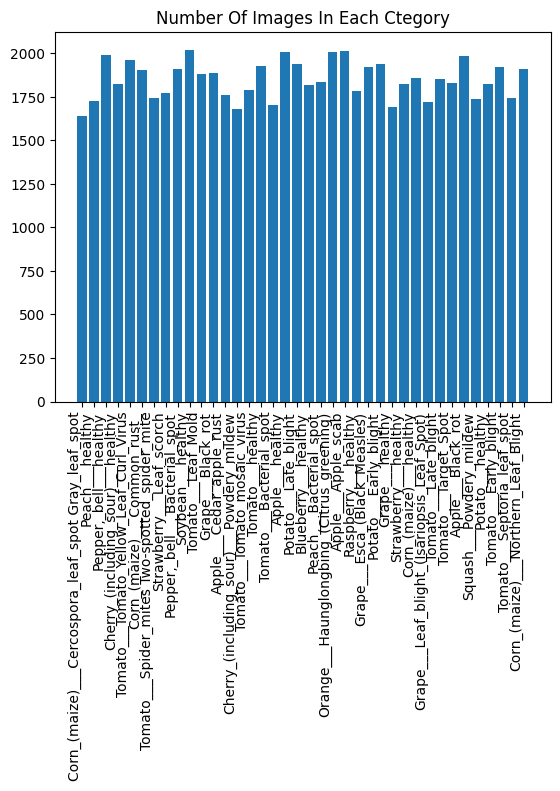

In [11]:
### VISUILIZATION
categ = np.array(TRAIN_INFORMATION['CATEGORY'])
Num = np.array(TRAIN_INFORMATION['NUM_IMAGES'])
x_pos = np.arange(len(categ))
plt.bar(x_pos , Num )
plt.title("Number Of Images In Each Ctegory")
plt.xticks(x_pos , categ , rotation=90 , ha="right" )
plt.show()

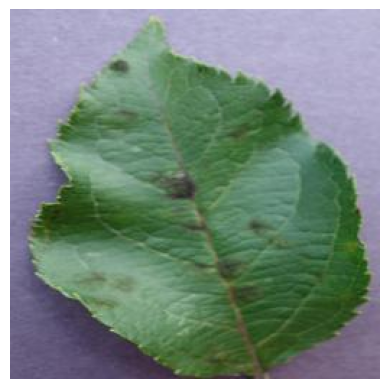

In [12]:
exempl_img = os.path.join("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
img = load_img(exempl_img)
img_array = img_to_array(img)
plt.imshow(img_array.astype(int))
plt.axis("off")
plt.show()

In [13]:
def images_vis(images_path) :
  fig , ax = plt.subplots(3,4)
  plt.figure(figsize=(8,8))
  axis = ax.flatten()
  for i,img in enumerate(os.listdir(images_path)) :
    img_path = os.path.join(images_path , img)
    img = load_img(img_path)
    img_arr = img_to_array(img)
    img_size = img_arr.shape
    axis[i].imshow(img_arr.astype('int'))
    axis[i].axis('off')
    if i ==11 :
      break
  plt.show()
  return img_size

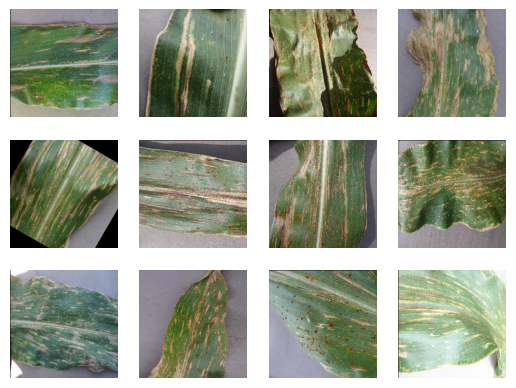

<Figure size 800x800 with 0 Axes>

In [14]:
imgs_path = os.path.join(config['TRAIN_PATH'] , os.listdir(config['TRAIN_PATH'])[0])
img_size = images_vis(imgs_path)

In [15]:
IMG_SIZE = img_array.shape
print(f'The Sise Of The Image is : {IMG_SIZE}')

The Sise Of The Image is : (256, 256, 3)


In [16]:
"""IMGAE NORMALIZATION"""
def Normalize(imgs, labels) :
    imgs = imgs /255.0
    return imgs , labels


In [17]:
"""TRAINING"""
train_data = image_dataset_from_directory(
    config['TRAIN_PATH'] ,
    batch_size=config['BATCH_SIZE'],
    image_size = config['IMG_SIZE'] ,
    shuffle=True ,
    seed = config['SEED'],
)

Found 70295 files belonging to 38 classes.


In [18]:
config['CLASSES_NAME'] = train_data.class_names
config['CLASSES_NAME']

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [19]:
"""VALIDATION """
val_data = image_dataset_from_directory(
    config['VAL_TEST_PATH'] ,
    batch_size=config['BATCH_SIZE'],
    image_size = config['IMG_SIZE'] ,
    shuffle=True ,
    seed = config['SEED'],
)

Found 17572 files belonging to 38 classes.


In [20]:
train_exemple = iter(train_data).next()

In [21]:
70295 / 128

549.1796875

In [22]:
img_iter = iter(train_data)
for batch_img in img_iter :
    print(batch_img[0].shape) ## EXPECTED (32,3,224,224)
    print(batch_img[1].shape) ### EXPECTED (32,)
    break

(32, 224, 224, 3)
(32,)


In [23]:
for batch_img in img_iter :
    print(batch_img[0])
    exemple = batch_img[0]
    break

tf.Tensor(
[[[[106.07143  110.07143  109.07143 ]
   [106.28571  110.28571  109.28571 ]
   [107.428566 111.428566 110.428566]
   ...
   [ 83.09696   87.09696   86.09696 ]
   [ 85.30103   89.30103   88.30103 ]
   [ 86.576546  90.576546  89.576546]]

  [[107.015305 111.015305 110.015305]
   [107.38265  111.38265  110.38265 ]
   [108.35714  112.35714  111.35714 ]
   ...
   [ 81.36225   85.36225   84.36225 ]
   [ 82.26021   86.26021   85.26021 ]
   [ 82.42857   86.42857   85.42857 ]]

  [[107.04591  111.04591  110.04591 ]
   [107.64286  111.64286  110.64286 ]
   [108.       112.       111.      ]
   ...
   [ 84.841835  88.841835  87.841835]
   [ 84.43367   88.43367   87.43367 ]
   [ 84.025505  88.025505  87.025505]]

  ...

  [[127.49999  136.49998  133.49998 ]
   [129.57141  138.57141  135.57141 ]
   [130.22958  139.22958  136.22958 ]
   ...
   [ 84.34188   89.34188   83.34188 ]
   [ 84.780624  89.780624  83.780624]
   [ 81.8571    86.8571    80.8571  ]]

  [[127.14286  136.14285  133.1428

In [24]:
img_val_iter = iter(val_data)
for batch_img in img_val_iter :
    print(batch_img[0].shape) ## EXPECTED (32,3,224,224)
    print(batch_img[1].shape) ### EXPECTED (32,)
    break

(32, 224, 224, 3)
(32,)


In [25]:
def To_Categorical(imgs , labels) :
  return imgs , tf.one_hot(labels, depth=38)

In [26]:
train_ds = train_data.map(Normalize).map(To_Categorical)
val_ds = val_data.map(Normalize).map(To_Categorical)

In [27]:
"""VERIFICATION"""
img_ds_iter = iter(train_ds)
for batch_ds_img in img_ds_iter :
    print('imges.............')
    print(batch_ds_img[0])
    print('lebels...........')
    print(batch_ds_img[1])
    break

imges.............
tf.Tensor(
[[[[0.40618247 0.6297119  0.50422174]
   [0.4019608  0.6254902  0.5       ]
   [0.397579   0.6211084  0.49561825]
   ...
   [0.36862755 0.60392165 0.47058833]
   [0.37186876 0.6071629  0.4681072 ]
   [0.3722489  0.60754305 0.46640655]]

  [[0.38733494 0.61086434 0.48537415]
   [0.38589436 0.60942376 0.48393357]
   [0.38317326 0.6067027  0.48121247]
   ...
   [0.34817937 0.5826331  0.45098048]
   [0.35780317 0.59225696 0.46060428]
   [0.3633054  0.59853953 0.4596038 ]]

  [[0.3882353  0.6117647  0.4862745 ]
   [0.3842937  0.60782313 0.48233292]
   [0.38229293 0.6058223  0.48033214]
   ...
   [0.32010812 0.55148065 0.4287916 ]
   [0.32945183 0.5608244  0.4381353 ]
   [0.33501408 0.5687276  0.44135654]]

  ...

  [[0.24995989 0.485254   0.35192066]
   [0.25072014 0.48601428 0.35268095]
   [0.24833913 0.48363325 0.35029992]
   ...
   [0.4154063  0.6350141  0.59187686]
   [0.41878763 0.6383955  0.59525824]
   [0.42062837 0.64023626 0.59709895]]

  [[0.25300124 

In [31]:
"""build model"""
def build_model(input_shape= (224,224,3) , num_classes = 38) :
    base_model =tf.keras.applications.mobilenet_v2.MobileNetV2(
        weights = "imagenet" ,
        input_shape= input_shape ,
        include_top = False ,
    ) ##USE VGG16 TO EXTRACT FEATURES
    for layer in base_model.layers :
        layer.trainable = False ## SET THE FIRST LAYERS OF BASE MODEL TO BE non-trainable TO SAVE TIIME
    model_input = Input(shape=input_shape)
    x = base_model(model_input)
    x = GlobalAveragePooling2D()(x ) ## TO FALTTEN THE OUTPUT OF VGG16 FIRST LAYERS
    x = tf.keras.layers.BatchNormalization(name='BatchNormalization_1')(x)
    x = Dense(128,activation="relu" , name="Desne_1")(x)
    x = tf.keras.layers.BatchNormalization(name='BatchNormalization_2')(x)

    model_output = Dense(num_classes , activation="softmax" , name="Output")(x) ## WE USE SOFTMAX BECOUSE WE HEVE MULTICLASSFICATION TASK
    return Model(inputs = model_input , outputs = model_output)



In [32]:
model = build_model()

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 BatchNormalization_1 (Batc  (None, 1280)              5120      
 hNormalization)                                                 
                                                                 
 Desne_1 (Dense)             (None, 128)               163968    
                                                           

In [34]:
### def my own callbacks
import time
import numpy as np
from tensorflow.keras import callbacks

class MyCallback(keras.callbacks.Callback):
    def __init__(self, models, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.models = models
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss

        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.models.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.models.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0
        print('..............THE TRAINING BEGIN GOOD LUCK ....................................')
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        print('.............THE TRAINING END ..........................')
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.models.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')





    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.models.optimizer.learning_rate)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.models.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.models.optimizer.learning_rate, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.models.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.models.optimizer.learning_rate, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc


        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.models.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.models.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [35]:
""" DEFINE CALLBACKS """
Early_stoping_Callbacks = EarlyStopping(monitor="val_loss" , patience=3  )
Csv_Logger = CSVLogger("training.log") # SAVE ALL THE IMPROVMENT OF THE MODEL IN CSV FILE
ReduceLR  = ReduceLROnPlateau(monitor="val_loss" , patience=2) # REDUCE LEARNING RATE
callbacks =[Early_stoping_Callbacks , Csv_Logger , ReduceLR]

In [36]:
"""Define the matrics """
OPTIMIZER = tf.keras.optimizers.Adam()

In [37]:
model.compile(
    optimizer = OPTIMIZER ,
    loss = tf.keras.losses.CategoricalCrossentropy() ,
    metrics=['accuracy' , tf.keras.metrics.CategoricalCrossentropy()]

)

In [38]:
history = model.fit(train_ds ,validation_data=val_ds , epochs=50 , callbacks = callbacks)

Epoch 1/50
2197/2197 [==============================] - 137s 58ms/step - loss: 0.3028 - accuracy: 0.9109 - categorical_crossentropy: 0.3028 - val_loss: 0.1452 - val_accuracy: 0.9528 - val_categorical_crossentropy: 0.1452 - lr: 0.0010
Epoch 2/50
2197/2197 [==============================] - 126s 57ms/step - loss: 0.1222 - accuracy: 0.9590 - categorical_crossentropy: 0.1222 - val_loss: 0.1195 - val_accuracy: 0.9617 - val_categorical_crossentropy: 0.1195 - lr: 0.0010
Epoch 3/50
2197/2197 [==============================] - 122s 55ms/step - loss: 0.0878 - accuracy: 0.9705 - categorical_crossentropy: 0.0878 - val_loss: 0.1220 - val_accuracy: 0.9604 - val_categorical_crossentropy: 0.1220 - lr: 0.0010
Epoch 4/50
2197/2197 [==============================] - 122s 56ms/step - loss: 0.0698 - accuracy: 0.9761 - categorical_crossentropy: 0.0698 - val_loss: 0.1187 - val_accuracy: 0.9634 - val_categorical_crossentropy: 0.1187 - lr: 0.0010
Epoch 5/50
2197/2197 [==============================] - 140s 64m

In [39]:
"""SAVE THE MODEL"""
model.save('PlantDeseaseDetection97.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
eavl = model.evaluate(val_ds)
print(eval)

550/550 [==============================] - 29s 51ms/step - loss: 0.0881 - accuracy: 0.9760 - categorical_crossentropy: 0.0881
<built-in function eval>


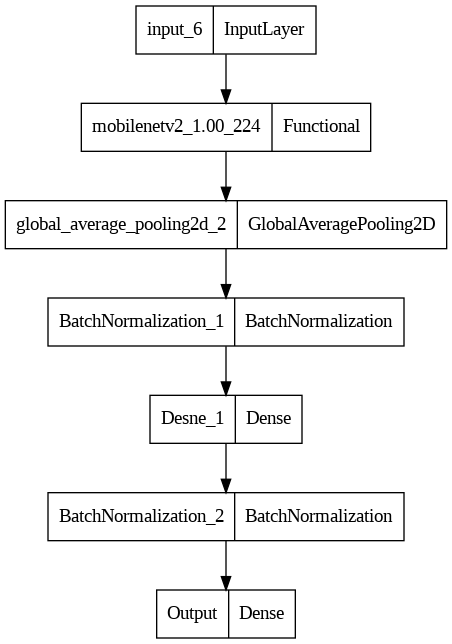

In [41]:
tf.keras.utils.plot_model(
    model ,
    to_file= "MOBILENET_pretrained2.png"
)

In [42]:
###PLOT THE MODEL
model_information = pd.DataFrame(history.history)
model_information

loss  accuracy  categorical_crossentropy  val_loss  val_accuracy  \
0   0.302757  0.910890                  0.302757  0.145169      0.952766   
1   0.122230  0.958959                  0.122230  0.119515      0.961700   
2   0.087772  0.970510                  0.087772  0.121957      0.960448   
3   0.069814  0.976101                  0.069814  0.118693      0.963351   
4   0.056867  0.980255                  0.056867  0.111782      0.965115   
5   0.048740  0.983342                  0.048740  0.124382      0.962270   
6   0.040112  0.986030                  0.040112  0.114740      0.966310   
7   0.024422  0.991962                  0.024422  0.090231      0.973367   
8   0.017167  0.994537                  0.017167  0.088307      0.974391   
9   0.014585  0.995889                  0.014585  0.088467      0.974619   
10  0.012295  0.996657                  0.012295  0.087939      0.974505   
11  0.011434  0.997013                  0.011434  0.087033      0.975359   
12  0.010114  0.997468                  0.010114  0.089459      0.975472   
13  0.009240  0.997980                  0.009240  0.088388      0.976212   
14  0.007865  0.998122                  0.007865  0.088126      0.976041   

    val_categorical_crossentropy       lr  
0                       0.145169  0.00100  
1                       0.119515  0.00100  
2                       0.121957  0.00100  
3                       0.118693  0.00100  
4                       0.111782  0.00100  
5                       0.124382  0.00100  
6                       0.114740  0.00100  
7                       0.090231  0.00010  
8                       0.088307  0.00010  
9                       0.088467  0.00010  
10                      0.087939  0.00010  
11                      0.087033  0.00010  
12                      0.089459  0.00010  
13                      0.088388  0.00010  
14                      0.088126  0.00001

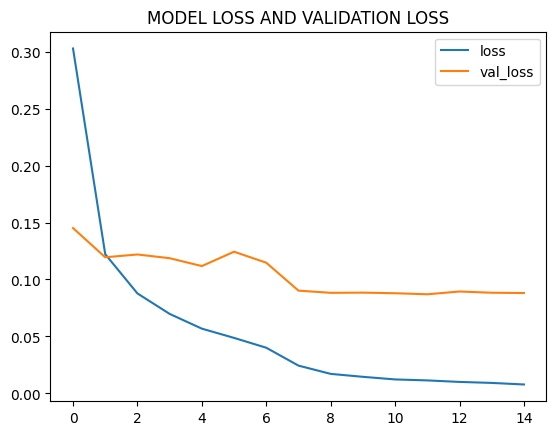

In [46]:
"""VISULIZE MODEL """
plt.plot(np.arange(15) , model_information['loss'] , label="loss")
plt.plot(np.arange(15) , model_information['val_loss'] , label="val_loss")
plt.title('MODEL LOSS AND VALIDATION LOSS')
plt.savefig('MOBILE_pretrained_loss.png')
plt.legend()
plt.show()


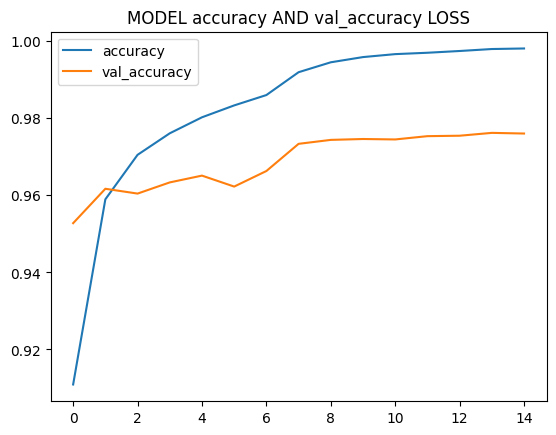

In [47]:
"""VISULIZE MODEL """
plt.plot(np.arange(15) , model_information['accuracy'] , label="accuracy")
plt.plot(np.arange(15) , model_information['val_accuracy'] , label="val_accuracy")
plt.title('MODEL accuracy AND val_accuracy LOSS')
plt.savefig('MOBILE_pretrained_val_accuracy.png')
plt.legend()
plt.show()


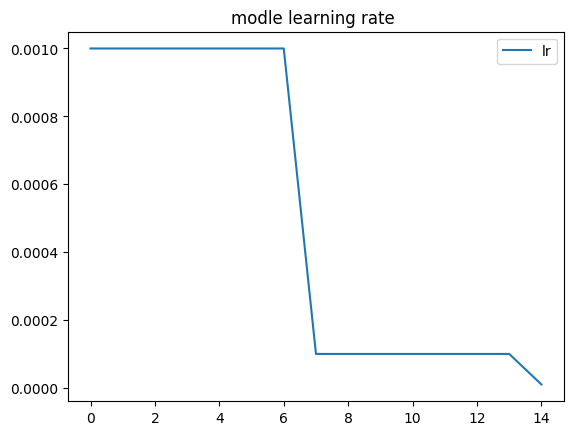

In [48]:
"""VISULIZE MODEL """
plt.plot(np.arange(15) , model_information['lr'] , label="lr")
plt.title('modle learning rate ')
plt.savefig('MOBILE_pretrained_lr.png')
plt.legend()
plt.show()

In [49]:
model_information.to_csv('mobile_pretrained_information')

In [63]:
#TEST VISULIZATION
"""VISULIZE FUNCTION"""

def VISUALIZE_IMAGES(images):
    fig, ax = plt.subplots(3, 4, figsize=(15, 9))
    for i in range(3):
        for j in range(4):
            img, label = TEST_PRE_PROCESING(images[i * 4 + j])
            prediction = model.predict(img , verbose=0)
            pred_label = np.argmax(prediction)
            image = load_img(images[i * 4 + j][0])
            ax[i, j].imshow(image)
            ax[i, j].axis('off')
            label = GetAllText(label)
            pred_label = GetAllText(config['CLASSES_NAME'][pred_label])
            color = 'red'
            if pred_label == label :
              color = 'green'
            ax[i, j].set_title(f"Prediction: {pred_label} \n, Label: {label}" , color = color)
    plt.tight_layout()
    plt.show()

""" PRE_PROCESS_TEST_DATA """

def TEST_PRE_PROCESING(img) :
  image = load_img(img[0])
  resize_img = tf.image.resize(image , (224,224))
  img_array = img_to_array(resize_img)
  img_array , label = Normalize(img_array ,img[1] )
  return tf.expand_dims(img_array , axis=0) ,label ##TO MAKE IT (BATCH , 224,224,3)

In [101]:
all_images = []
for dir in os.listdir(config['TEST_PATH']) :
  new_path = os.path.join(config['TEST_PATH'] , dir)
  i  =0
  for img in os.listdir(new_path) :
    filename , ext = os.path.splitext(img)
    all_images.append([os.path.join(new_path , img) , filename])
images = all_images[:12]


In [95]:
all_val_images = []
img = iter(val_ds).next()
i = 0
for image,label in zip(img[0], img[1]) :
  all_val_images.append([image , label])
  i = i+1
  if i == 12 :
    break

In [96]:
def viz_valid_images(images):
    fig, ax = plt.subplots(3, 4, figsize=(15, 9))
    axis = ax.flatten()
    for i in range(12):
        image_data, label = images[i]
        pred = model.predict(np.expand_dims(image_data, axis=0), verbose=0)
        pred_label = np.argmax(pred)
        true_label = np.argmax(label)

        pred_label_name = config['CLASSES_NAME'][pred_label]
        true_label_name = config['CLASSES_NAME'][true_label]

        color = 'red' if pred_label != true_label else 'green'

        axis[i].imshow(image_data)
        axis[i].axis('off')
        axis[i].set_title(f"Prediction: {pred_label_name}\nLabel: {true_label_name}", color=color,fontsize=8)

    plt.tight_layout()
    plt.show()

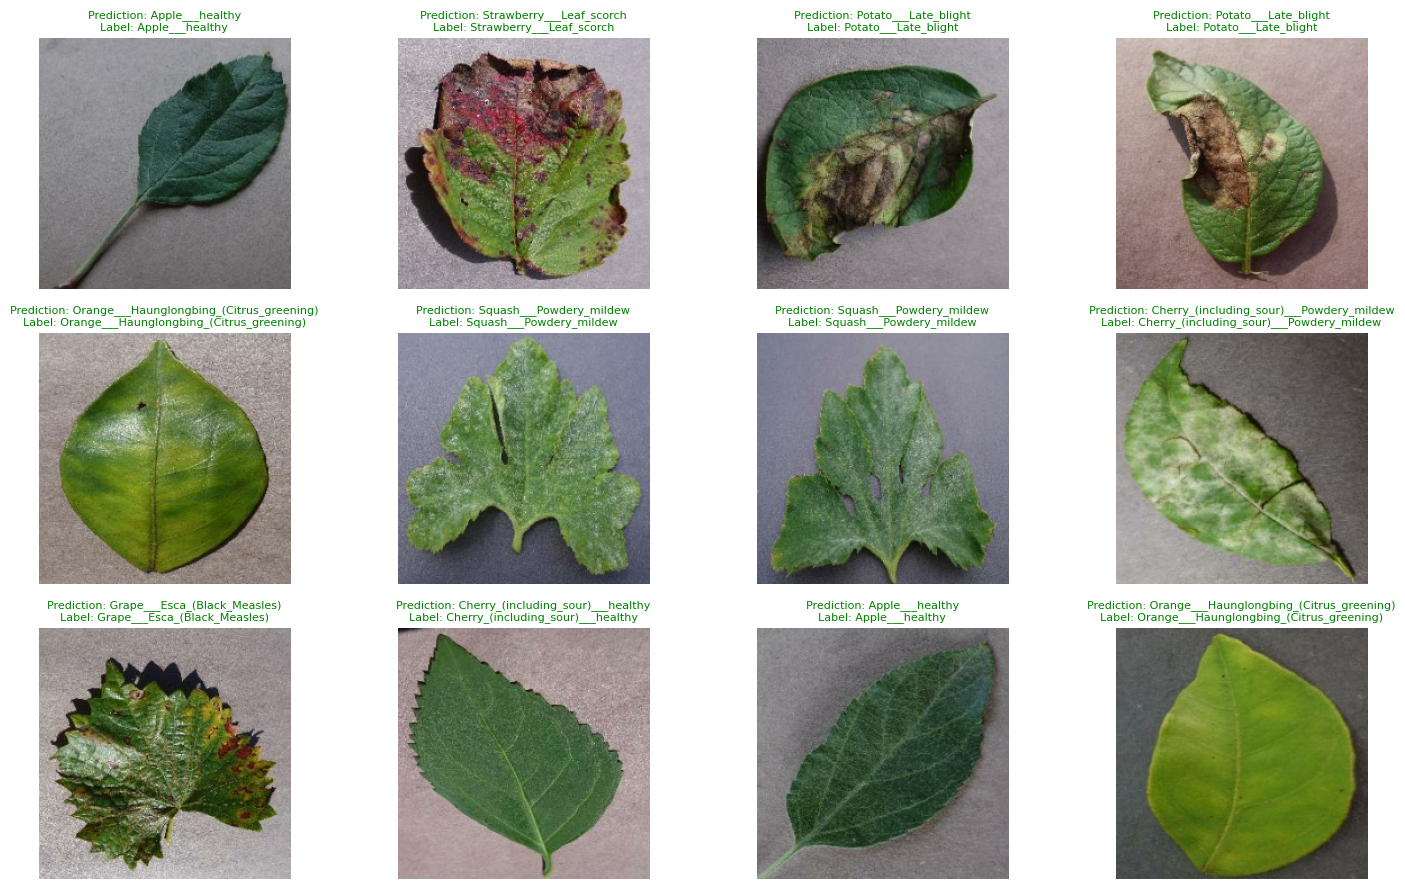

In [97]:
viz_valid_images(all_val_images)

In [58]:
def GetAllText(text):
    chr = ['___' , '_']
    new = ""
    for char in text :
      if char not in chr :
        new = new + char
    return new

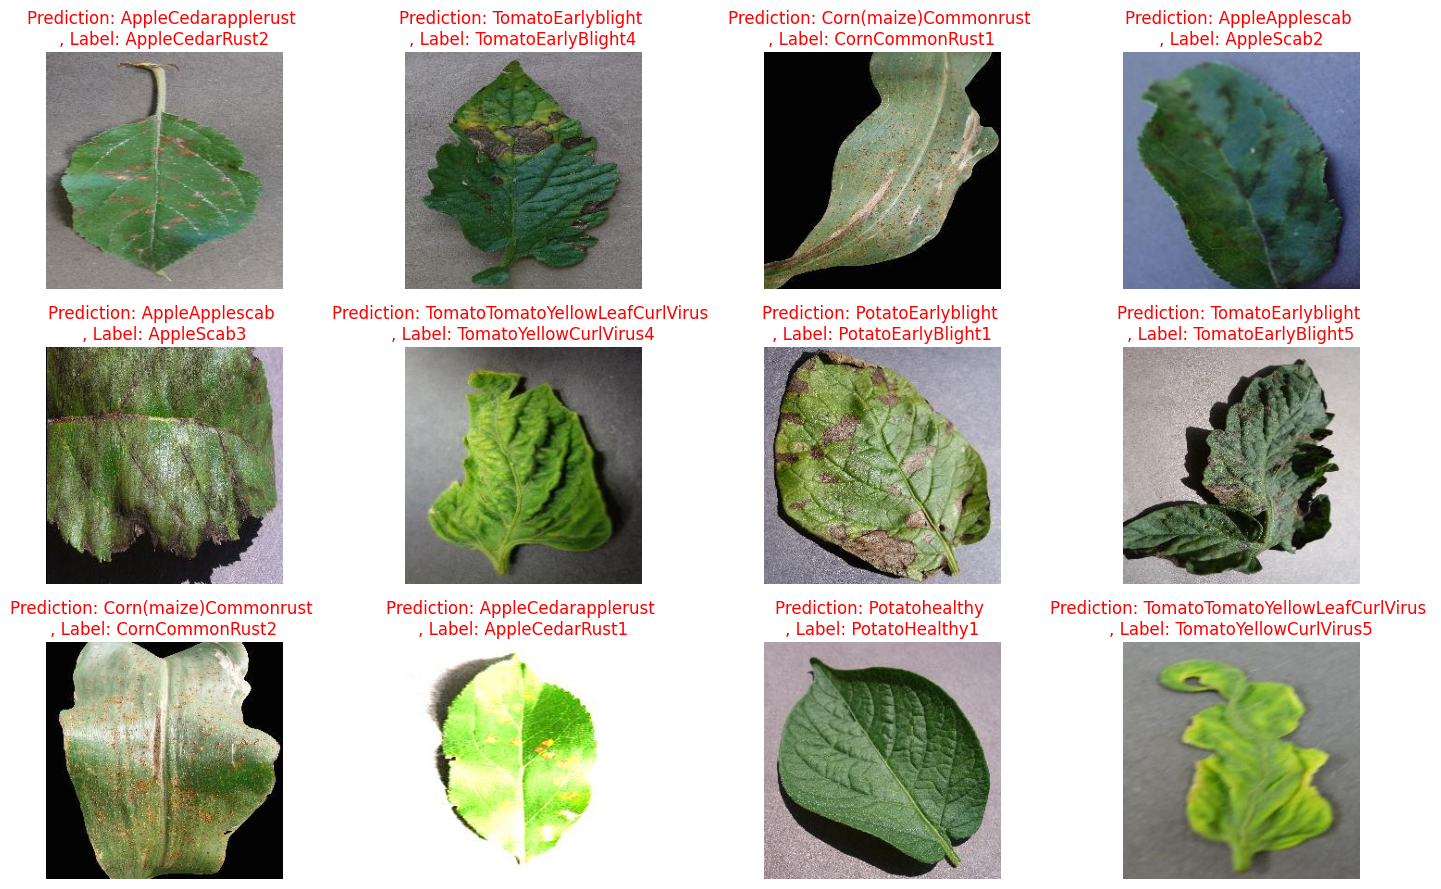

In [64]:
VISUALIZE_IMAGES(images)

In [102]:
###TEST ACCURACY :
class TEST_DATA() :
  def __init__(self, images):
     self.images = images
  def TestPredection(self) :
    predections = []
    true_labels = []
    for img in self.images :
      image, label = TEST_PRE_PROCESING(img)
      prediction = model.predict(image, verbose=0)
      pred_label = np.argmax(prediction)
      predections.append(config['CLASSES_NAME'][pred_label])
      true_labels.append(label)
    return true_labels ,predections
  def Accuracy(self , pred , true) :
    self.i = 0
    for i in range(len(pred)) :
      if pred[i] == true[i] :
        self.i += 1
    assert len(pred) != 0
    return f'{self.i*100/len(pred)} % accuracy '

In [103]:
Test_Acurracy = TEST_DATA(all_images)
test_true_label , test_predection = Test_Acurracy.TestPredection()

In [104]:
test_predection

['Apple___Cedar_apple_rust',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Apple___Apple_scab',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Potato___Early_blight',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Apple___Cedar_apple_rust',
 'Potato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Potato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Tomato___healthy',
 'Apple___Cedar_apple_rust',
 'Apple___Cedar_apple_rust',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Early_blight',
 'Potato___healthy',
 'Tomato___Late_blight',
 'Potato___Early_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Late_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Tomato___Early_blight']

In [105]:
test_true_label

['AppleCedarRust2',
 'TomatoEarlyBlight4',
 'CornCommonRust1',
 'AppleScab2',
 'AppleScab3',
 'TomatoYellowCurlVirus4',
 'PotatoEarlyBlight1',
 'TomatoEarlyBlight5',
 'CornCommonRust2',
 'AppleCedarRust1',
 'PotatoHealthy1',
 'TomatoYellowCurlVirus5',
 'TomatoHealthy1',
 'PotatoEarlyBlight3',
 'CornCommonRust3',
 'PotatoEarlyBlight2',
 'PotatoEarlyBlight4',
 'TomatoHealthy4',
 'AppleCedarRust3',
 'AppleCedarRust4',
 'AppleScab1',
 'TomatoYellowCurlVirus1',
 'TomatoHealthy2',
 'TomatoYellowCurlVirus3',
 'TomatoEarlyBlight3',
 'PotatoHealthy2',
 'TomatoEarlyBlight1',
 'PotatoEarlyBlight5',
 'TomatoYellowCurlVirus6',
 'TomatoEarlyBlight2',
 'TomatoYellowCurlVirus2',
 'TomatoHealthy3',
 'TomatoEarlyBlight6']

In [106]:
"""
WE SEE THAT OUR NAMES IN TEST ARE NOT SIMILARE IN OUR IN TRAINING SO WE ARE GOING TO RENAME THEM
"""
NAMES_TRANSFORM = {
    'PotatoEarlyBlight': 'Potato___Early_blight' ,
    'TomatoHealthy': 'Tomato___healthy' ,
    'AppleScab': 'Apple___Apple_scab' ,
    'PotatoEarlyBlight': 'Potato___Early_blight' ,
    'TomatoYellowCurlVirus': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' ,
    'TomatoHealthy': 'Tomato___healthy',
    'CornCommonRust': 'Corn_(maize)___Common_rust_' ,
    'PotatoHealthy': 'Potato___healthy',
    'AppleCedarRust': 'Apple___Cedar_apple_rust' ,
    'AppleScab': 'Apple___Apple_scab',
    'TomatoEarlyBlight': 'Tomato___Early_blight' ,
}

In [107]:
true_labels = []
for i in range(len(test_true_label)) :
  if test_true_label[i][:-1] in list(NAMES_TRANSFORM.keys()) :
    true_labels.append(NAMES_TRANSFORM[test_true_label[i][:-1]])
#BECOUSE WE HAVE A NUMBER IN THE END OF EACH ITEM WE WILL REMOVE IT

In [108]:
true_labels

['Apple___Cedar_apple_rust',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Apple___Apple_scab',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Potato___Early_blight',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Apple___Cedar_apple_rust',
 'Potato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Potato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Tomato___healthy',
 'Apple___Cedar_apple_rust',
 'Apple___Cedar_apple_rust',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Early_blight',
 'Potato___healthy',
 'Tomato___Early_blight',
 'Potato___Early_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Early_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Tomato___Early_blight']

In [109]:
accuracy = Test_Acurracy.Accuracy(test_predection,true_labels)
print(accuracy)

93.93939393939394 % accuracy 
